<a href="https://colab.research.google.com/github/slubskiy/heart_risk/blob/master/heart_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Общая информация и цель проекта
В этом проекте предполагается работа с датасетом из открытого источника. Вам потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. В начале проекта вам будет доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также вам будет доступен скрипт, с помощью которого будет измеряться финальная метрика вашей модели.


# Задачи проекта
Предполагается, что в ходе работы над проектом будут решены следующие задачи:
* Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
* Предобработка данных. Будьте внимательны: в данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
*	Обучение модели
*	Подготовка предсказания на тестовой выборке. Обратите внимание. Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”.
*	Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
*	Написание инструмента для тестирования
*	Оформление документации


# Описание исходных данных
Данные пациентов для предсказания риска сердечных приступов
- id  - id
-	Антропометрические параметры (вес, возраст, рост)
-	Привычки (курение, качество сна и т.д)
-	Давление
-	Наличие хронических заболеваний
-	Биохимия крови
-	Таргет - высокий или низкий риск поражения сердца


In [1]:
!pip install phik

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_columns', None)
RANDOM_STATE = 1000

In [3]:
try:
  test = pd.read_csv(r"C:\Users\evgen\project\hearth_risk\heart_test.csv")
  train = pd.read_csv(r"C:\Users\evgen\project\hearth_risk\heart_train.csv")
except:
  test = pd.read_csv("/content/heart_test.csv")
  train= pd.read_csv("/content/heart_train.csv")

In [4]:
test.head(5)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use        

In [6]:
test.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,966.00000,966.000000,966.000000,966.000000,935.000000,935.000000,935.000000,935.000000,935.000000,966.000000,966.000000,935.000000,935.000000,935.000000,966.000000,966.000000,966.000000,966.000000,935.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000,966.000000
mean,482.50000,0.452916,0.488181,0.051644,0.656684,0.481283,0.898396,0.516578,0.583957,0.490706,1.053830,0.494118,0.488770,5.332620,0.506715,0.484408,0.476796,0.486688,3.443850,0.512571,0.224127,0.048855,0.034926,0.447172,0.496822,4769.160455
std,279.00448,0.231068,0.282039,0.035502,0.475070,0.499917,0.302289,0.499993,0.493165,0.284902,0.884642,0.500233,0.500141,2.858466,0.287826,0.273879,0.291987,0.284534,2.302778,0.322292,0.065270,0.079742,0.053855,0.171837,0.173935,2818.815407
min,0.00000,0.044944,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000336,0.000000,0.000000,0.000000,1.000000,0.001187,0.003351,0.002598,0.000000,0.000000,0.000000,0.029644,0.000000,0.000194,0.012903,0.116279,0.000000
25%,241.25000,0.247191,0.243750,0.036664,0.000000,0.000000,1.000000,0.000000,0.000000,0.243431,0.000000,0.000000,0.000000,3.000000,0.258713,0.261446,0.217527,0.249675,1.000000,0.166667,0.227018,0.048229,0.036512,0.296774,0.348837,2275.750000
50%,482.50000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,1.000000,1.000000,0.502110,1.000000,0.000000,0.000000,5.000000,0.501327,0.492015,0.471185,0.488961,3.000000,0.500000,0.227018,0.048229,0.036512,0.445161,0.488372,4769.500000
75%,723.75000,0.640449,0.710714,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.734425,2.000000,1.000000,1.000000,8.000000,0.759591,0.705371,0.720503,0.718182,5.000000,0.833333,0.227018,0.048229,0.036512,0.600000,0.639535,7206.000000
max,965.00000,0.853933,0.996429,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.998938,3.000000,1.000000,1.000000,10.000000,0.999033,0.998885,0.999496,0.998701,7.000000,1.000000,0.750988,1.000000,0.970871,0.741935,0.790698,9644.000000


In [7]:
y = test.drop('Unnamed: 0', axis=1)
y.rename(columns=str.lower, inplace=True)
y.columns = y.columns.str.replace(" ", "_")
y = y.set_index('id')

y.head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,
7746,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,0.0,0.0,8.0,0.194370,0.587759,0.283490,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093
4202,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,1.0,1.0,5.0,0.329888,0.602883,0.467036,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860
6632,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,0.0,0.0,10.0,0.780075,0.370436,0.409366,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070
4639,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,0.0,0.0,10.0,0.785071,0.368242,0.910261,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814
4825,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,0.0,0.0,7.0,0.070919,0.729578,0.758924,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349


In [8]:
train.head(5)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [10]:
train.describe()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,Previous Heart Problems,Medication Use,Stress Level,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Systolic blood pressure,Diastolic blood pressure,id
count,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8442.000000,8442.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8442.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000,8685.000000
mean,4342.000000,0.449958,0.501070,0.050658,0.652097,0.489576,0.902867,0.498342,0.601990,0.503378,1.057455,0.495380,0.501185,5.493367,0.499164,0.496055,0.496774,0.505484,3.508292,0.503737,0.346920,0.227339,0.048159,0.036689,0.450295,0.497634,4831.210823
std,2507.287877,0.231174,0.284716,0.023453,0.476333,0.499921,0.296157,0.500027,0.489517,0.284810,0.866645,0.500008,0.500028,2.867862,0.285340,0.284698,0.282561,0.286320,2.281772,0.328061,0.476017,0.076635,0.075531,0.060157,0.170184,0.171830,2782.585625
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2171.000000,0.258427,0.267857,0.034830,0.000000,0.000000,1.000000,0.000000,0.000000,0.263286,0.000000,0.000000,0.000000,3.000000,0.255875,0.251922,0.254190,0.263636,2.000000,0.166667,0.000000,0.227018,0.048229,0.036512,0.303226,0.348837,2425.000000
50%,4342.000000,0.460674,0.499780,0.050412,1.000000,0.000000,1.000000,0.000000,1.000000,0.502110,1.000000,0.000000,1.000000,5.000000,0.499920,0.494889,0.494774,0.503603,3.000000,0.500000,0.000000,0.227018,0.048229,0.036512,0.445161,0.500000,4837.000000
75%,6513.000000,0.640449,0.746429,0.065995,1.000000,1.000000,1.000000,1.000000,1.000000,0.748709,2.000000,1.000000,1.000000,8.000000,0.744623,0.741036,0.736974,0.750649,6.000000,0.833333,1.000000,0.227018,0.048229,0.036512,0.600000,0.651163,7242.000000
max,8684.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,10.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9650.000000


In [11]:
X_train = train.drop('Unnamed: 0', axis=1)
X_train.rename(columns=str.lower, inplace=True)
X_train.columns = X_train.columns.str.replace(" ", "_")
X_train = X_train.set_index('id')

X_train.head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


In [12]:
X_train.duplicated().sum()

np.int64(0)

In [13]:
X_train.isna().sum()

,0
age,0
cholesterol,0
heart_rate,0
diabetes,243
family_history,243
smoking,243
obesity,243
alcohol_consumption,243
exercise_hours_per_week,0
diet,0


In [14]:
X_train['physical_activity_days_per_week'].value_counts()

,count
physical_activity_days_per_week,
3.0,1091
2.0,1087
1.0,1069
7.0,1063
6.0,1055
5.0,1046
4.0,1025
0.0,1006


In [15]:
X_train['stress_level'].value_counts()

,count
stress_level,
7.0,869
4.0,857
2.0,854
9.0,852
8.0,844
3.0,841
1.0,840
5.0,833
6.0,828


In [16]:
X_train['gender'].value_counts()

,count
gender,
Male,5882
Female,2560
1.0,156
0.0,87


In [17]:
X_train = X_train[X_train['gender'].isin(['Male', 'Female'])]
X_train['gender'].value_counts()

,count
gender,
Male,5882
Female,2560


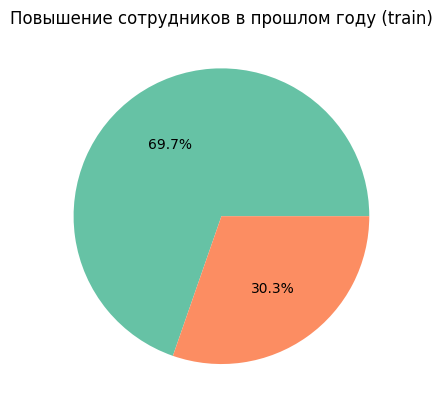

In [18]:
plt.pie(
    X_train['gender'].value_counts(),
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2')
)
plt.title('Повышение сотрудников в прошлом году (train)')
plt.grid()
plt.show()

In [19]:
def hist_box(data, column):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.xlabel('value')
    plt.ylabel('frequency')
    plt.title(column)
    sns.histplot(data[column])
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[column])

In [20]:
num = ['heart_rate',
       'age',
       'cholesterol',
       'exercise_hours_per_week',
       'sedentary_hours_per_day',
       'exercise_hours_per_week',
       'sedentary_hours_per_day',
       'income',
       'bmi',
       'triglycerides',
       'sleep_hours_per_day',
       'blood_sugar',
       'ck-mb',
       'troponin',
       'systolic_blood_pressure',
       'diastolic_blood_pressure'
]

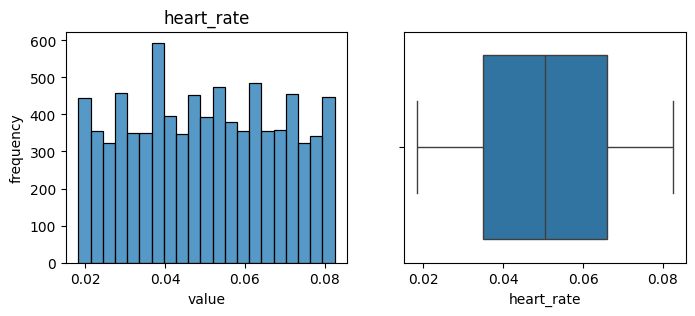

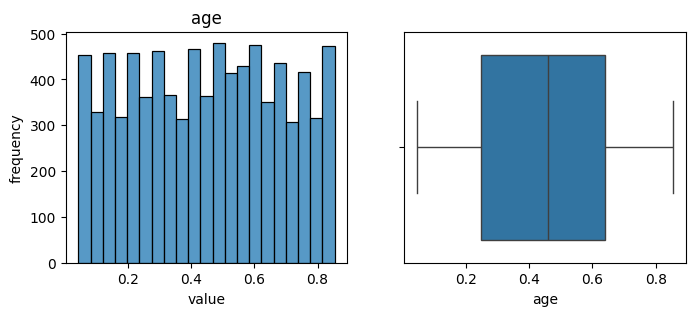

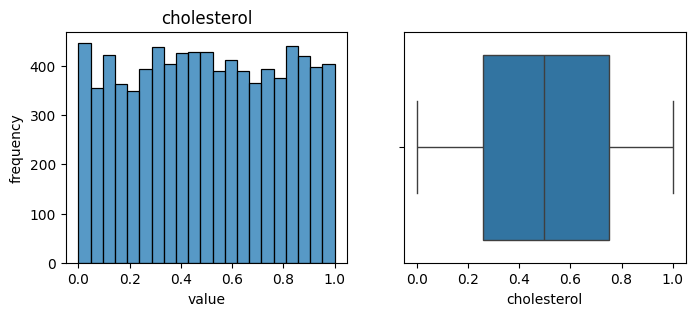

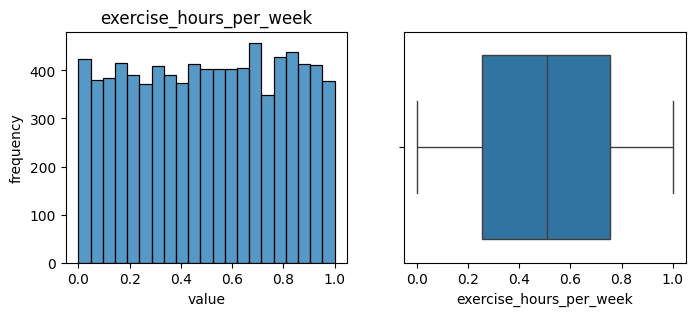

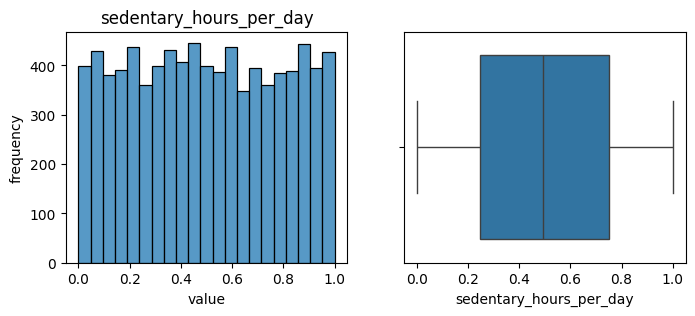

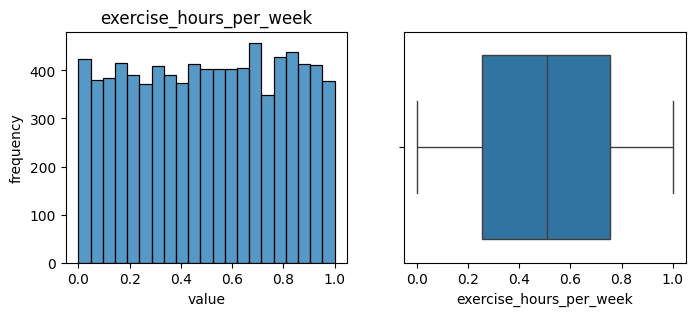

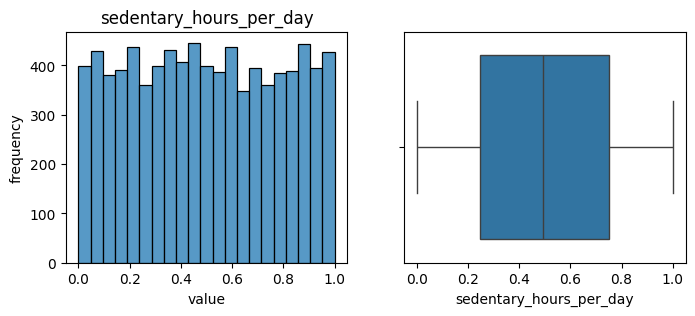

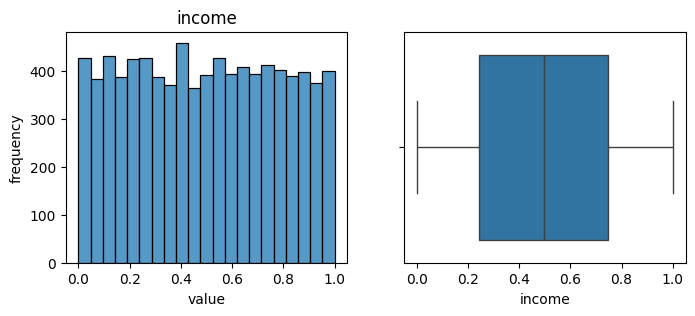

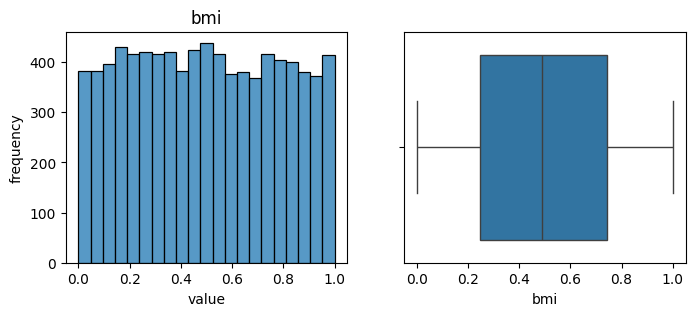

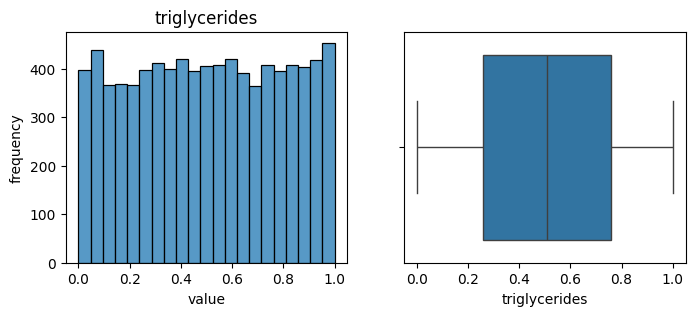

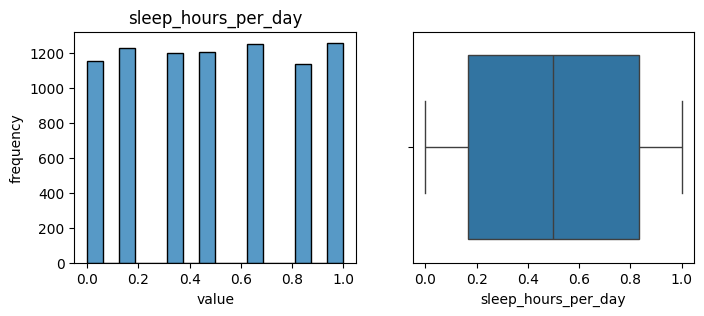

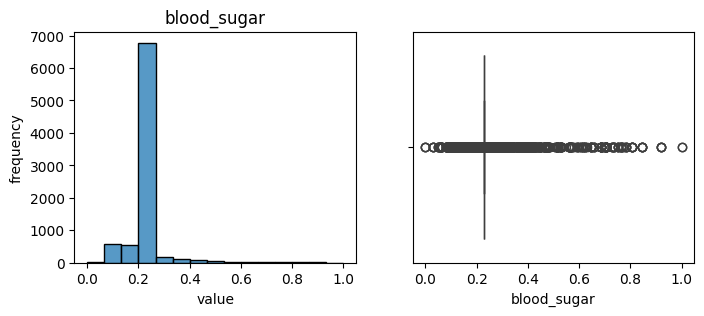

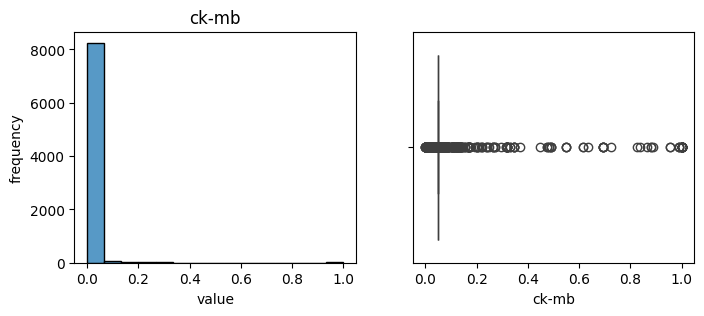

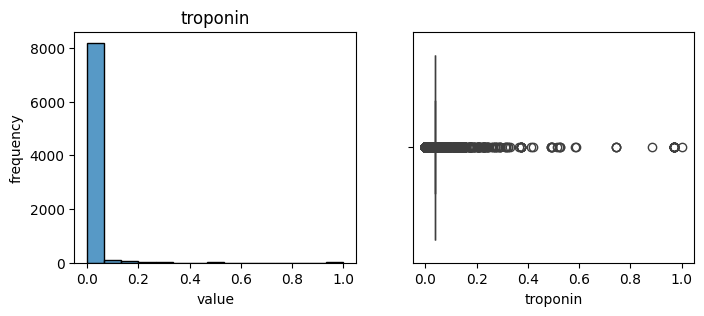

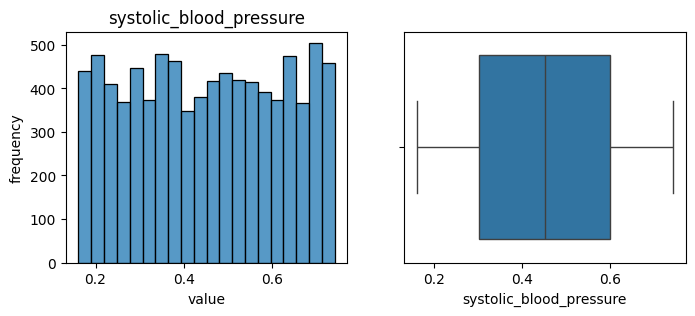

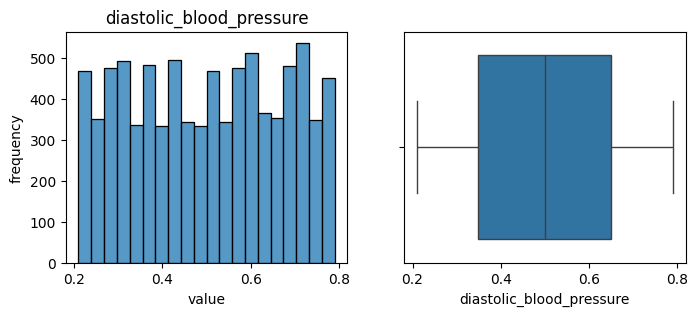

In [21]:
for name in num:
    hist_box(X_train, name)

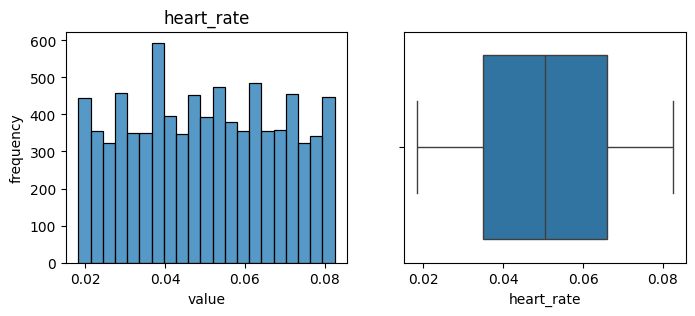

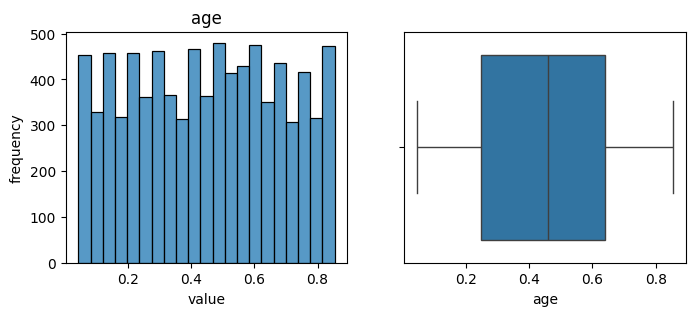

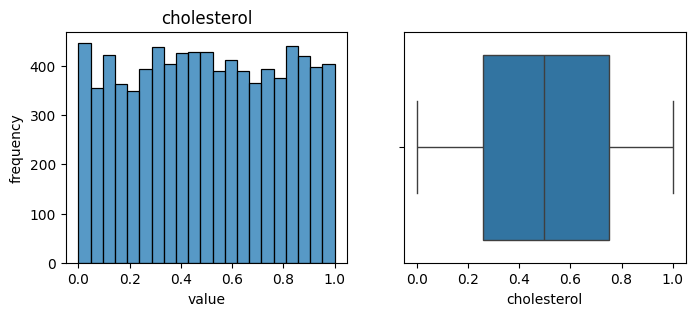

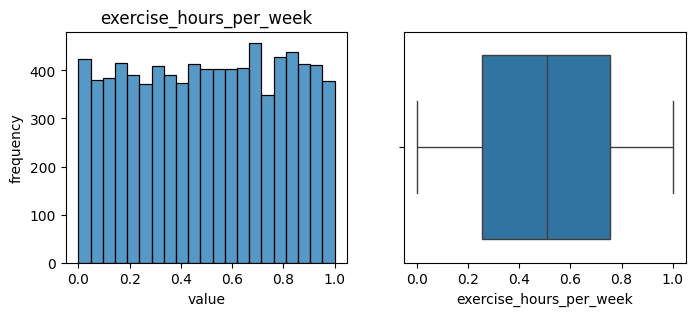

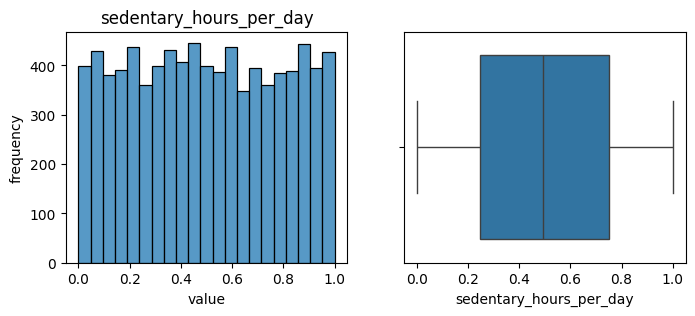

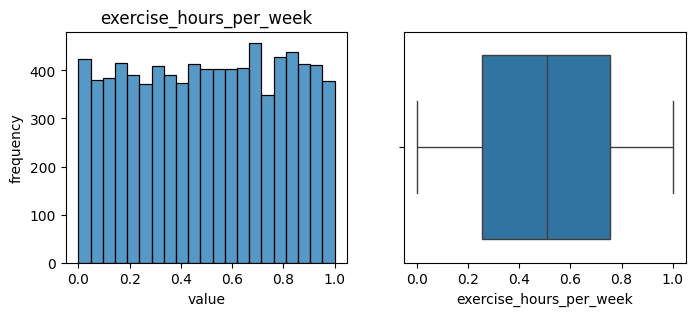

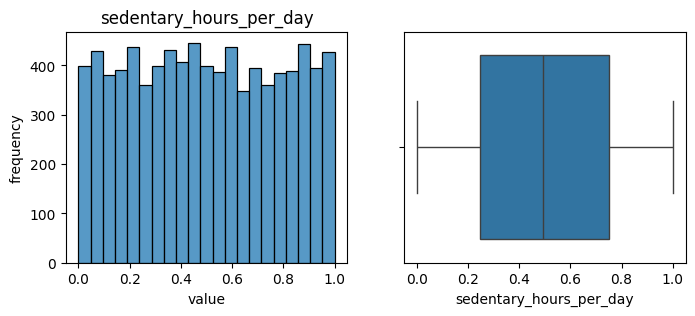

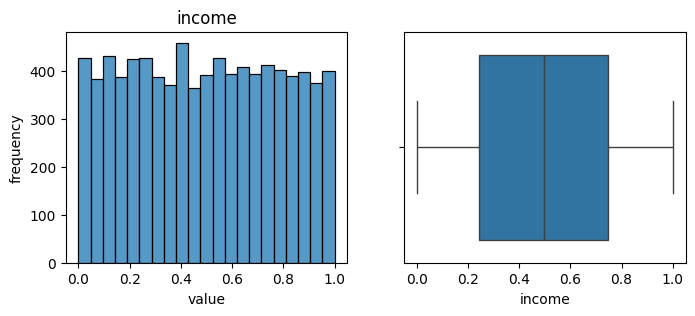

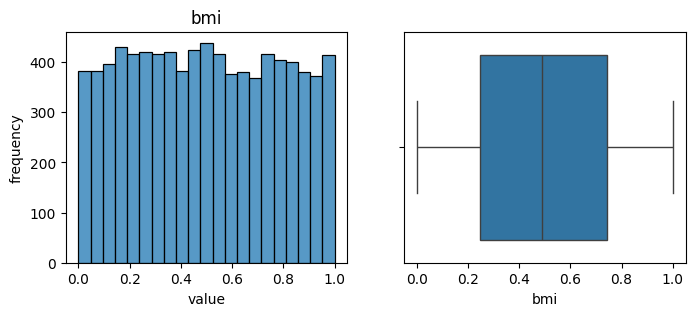

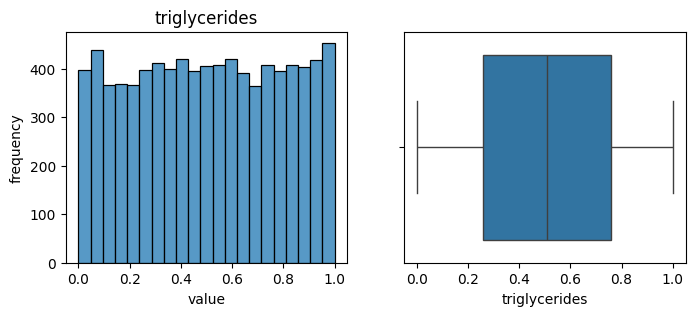

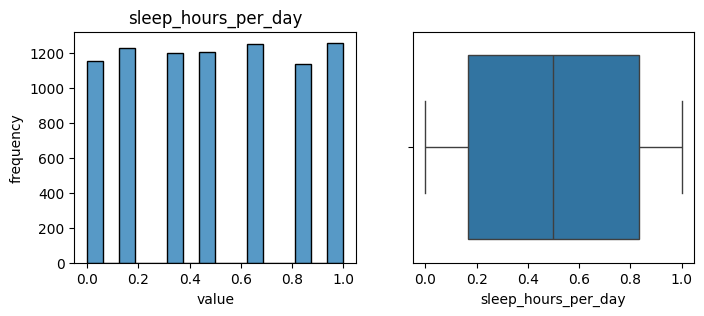

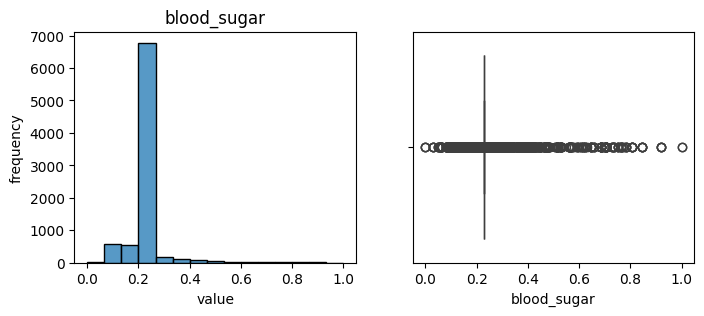

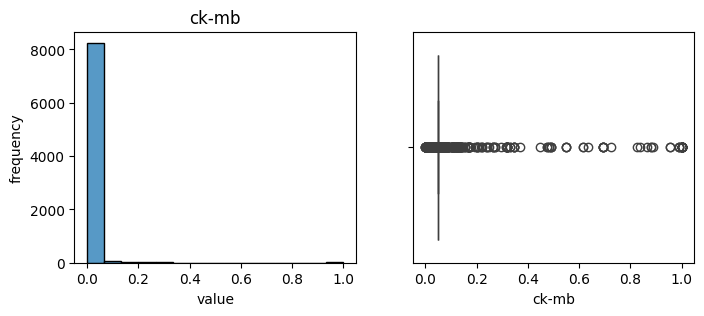

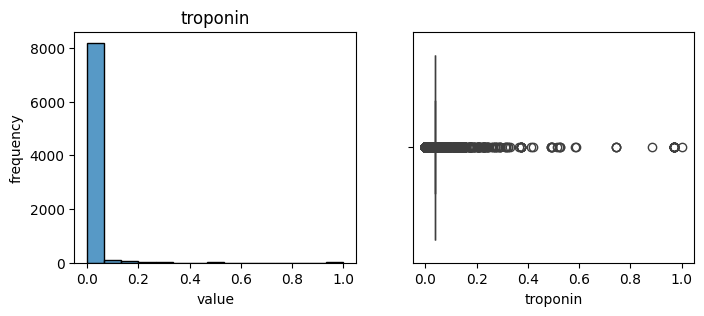

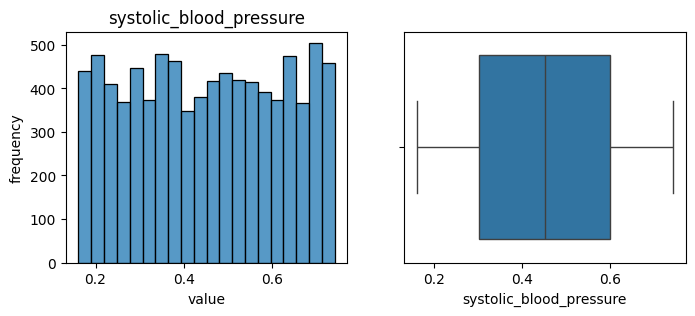

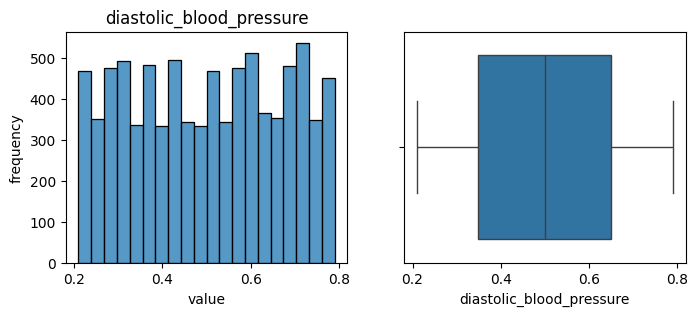

In [22]:
for name in num:
    hist_box(X_train, name)

In [23]:
X_train[X_train['troponin'] > 0.4].head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2614,0.393258,0.714286,0.050412,0.0,1.0,1.0,1.0,1.0,0.960997,2,0.0,1.0,10.0,0.526723,0.206665,0.171373,0.949351,5.0,0.833333,0.0,0.124506,0.124697,0.970871,Male,0.554839,0.372093
9363,0.528090,0.260714,0.036664,1.0,0.0,1.0,0.0,0.0,0.511968,0,0.0,1.0,1.0,0.822890,0.872269,0.912742,0.641558,7.0,1.000000,0.0,0.150198,0.001041,0.587339,Female,0.354839,0.430233
3646,0.606742,0.021429,0.036664,0.0,1.0,1.0,0.0,1.0,0.710575,2,0.0,1.0,6.0,0.046625,0.113029,0.158579,0.396104,4.0,1.000000,1.0,0.158103,0.007838,0.970871,Male,0.322581,0.627907
7866,0.629213,0.450000,0.039413,1.0,1.0,1.0,0.0,1.0,0.578846,0,1.0,0.0,1.0,0.860513,0.366452,0.475061,0.435065,5.0,0.333333,0.0,0.359684,0.004935,0.970871,Female,0.277419,0.255814
2164,0.550562,0.703571,0.062328,1.0,0.0,1.0,1.0,1.0,0.054217,0,1.0,0.0,1.0,0.005444,0.329938,0.144007,0.593506,3.0,1.000000,0.0,0.083004,0.006003,0.490242,Male,0.406452,0.534884


In [24]:
# вычисление коэффициентов корреляции phi
interval = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'diet',
    'previous_heart_problems',
    'medication_use',
    'stress_level',
    'physical_activity_days_per_week',
    'bmi',
    'exercise_hours_per_week',
    'income',
    'sedentary_hours_per_day'
    ]

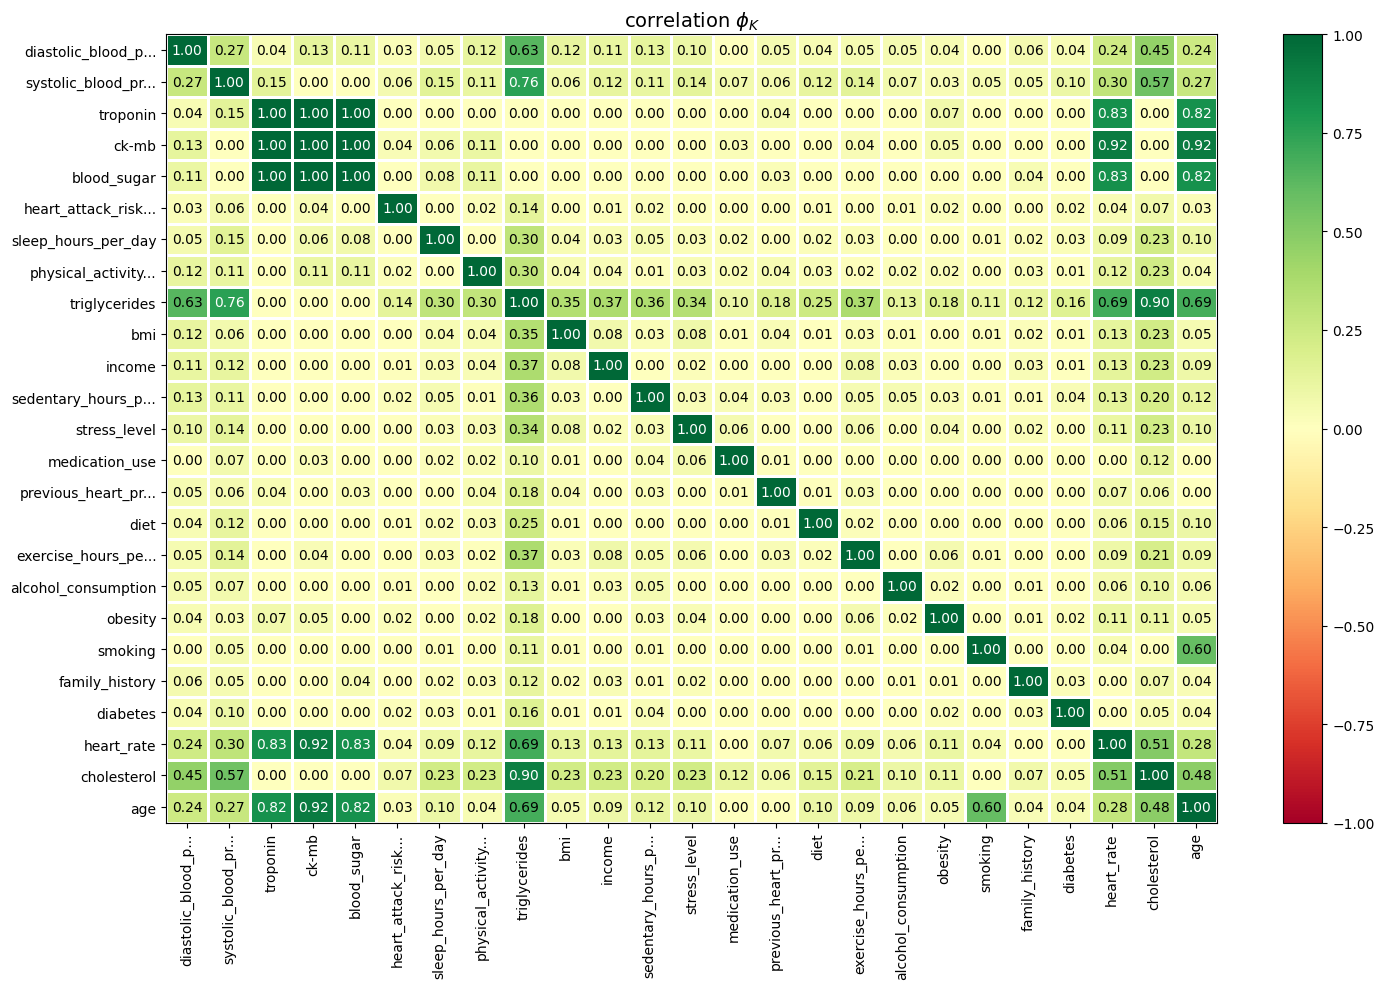

In [25]:
phik_X_train = phik_matrix(X_train.drop('gender', axis=1), interval_cols=interval)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_X_train.values,
    x_labels=phik_X_train.columns,
    y_labels=phik_X_train.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(15, 10)
)

In [26]:
Pipeline

sklearn.pipeline.Pipeline

In [27]:
X_train.head(5)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,previous_heart_problems,medication_use,stress_level,sedentary_hours_per_day,income,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_(binary),blood_sugar,ck-mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
id,,,,,,,,,,,,,,,,,,,,,,,,,,
2664,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,1.0,0.0,8.0,0.225704,0.105948,0.459176,0.979221,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302
9287,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,1.0,0.0,9.0,0.289923,0.164217,0.117053,0.515584,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767
5379,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,1.0,1.0,6.0,0.550133,0.598745,0.373574,0.012987,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930
8222,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,0.0,1.0,3.0,0.330962,0.077605,0.049735,0.131169,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442
4047,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,0.0,0.0,8.0,0.524600,0.341960,0.830405,0.070130,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860


In [28]:
#создаем списки признаков

ohe_columns = []

ord_columns = [
    'gender'
    ]

num_columns = [
    'age',
    'cholesterol',
    'heart_rate',
    'exercise_hours_per_week',
    'sedentary_hours_per_day',
    'income',
    'bmi',
    'triglycerides',
    'sleep_hours_per_day',
    'blood_sugar',
    'ck-mb',
    'troponin',
    'systolic_blood_pressure',
    'diastolic_blood_pressure'
    ]

#создаём пайплайны для подготовки признаков
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

ord_pipe = Pipeline(
    [
        (
            'ord', OrdinalEncoder(
                categories=[
                    ['Male', 'Female']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [29]:
#создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [30]:
#создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

In [34]:
param_grid = [
        {
            'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')], #solver='liblinear')],
            'models__penalty': ['l1', 'l2'],
            'models__C': range(1, 10),
            'models__solver': ['liblinear', 'saga'],
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {
            'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
            'models__max_depth': range(1, 21),
            'models__min_samples_leaf': range(1, 6),
            'models__min_samples_split': range(2, 6),
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        },
        {
            'models': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
            'models__n_neighbors': range(5, 20),
            'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
        }
]

In [32]:
X = X_train.drop('heart_attack_risk_(binary)', axis=1)
y = X_train['heart_attack_risk_(binary)']

In [ ]:
grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    n_jobs=-1,
    cv=10,
    scoring=roc_auc_score
)
grid_search.fit(X, y)